In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from IPython.display import display, Markdown

# set up the environment
%matplotlib inline
plt.rc("figure", figsize=(16, 6))  # set default size of plots
sns.set_style("whitegrid")  # set default seaborn style
rng = np.random.default_rng()  # random generator

## Question 5.1

In [2]:
def stock_tree(S0, sigma, T, N):
    """Stock price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps

    Returns:
        numpy.ndarray: stock price tree
    """
    dt = T / N  # time step
    u = np.exp(sigma * np.sqrt(dt))  # up factor (Cox-Ross-Rubinstein model)
    d = 1 / u  # down factor
    S = np.zeros((N + 1, N + 1))  # stock price tree
    S[0, 0] = S0  # initial stock price
    for t in range(1, N + 1):
        for i in range(t + 1):
            S[i, t] = S0 * u**(t - i) * d**i  # i down, t - i up
    return S


def euro_call_tree(S0, sigma, T, N, K, r, q=0):
    """European call option price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps
        K (float): strike price
        r (float): risk-free rate
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        numpy.ndarray: European call option price tree
    """
    S = stock_tree(S0, sigma, T, N)  # stock price tree
    dt = T / N  # time step
    u = np.exp(sigma * np.sqrt(dt))  # up factor
    d = 1 / u  # down factor
    p = (np.exp((r - q) * dt) - d) / (u - d)  # risk-neutral probability
    euro_call = np.zeros((N + 1, N + 1))  # European call option price tree
    for i in range(N + 1):
        euro_call[i, N] = max(S[i, N] - K, 0)  # payoff at maturity
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            euro_call[
                i,
                # backward induction
                t] = np.exp(-r * dt) * (p * euro_call[i, t + 1] + (1 - p) * euro_call[i + 1, t + 1])
    return euro_call

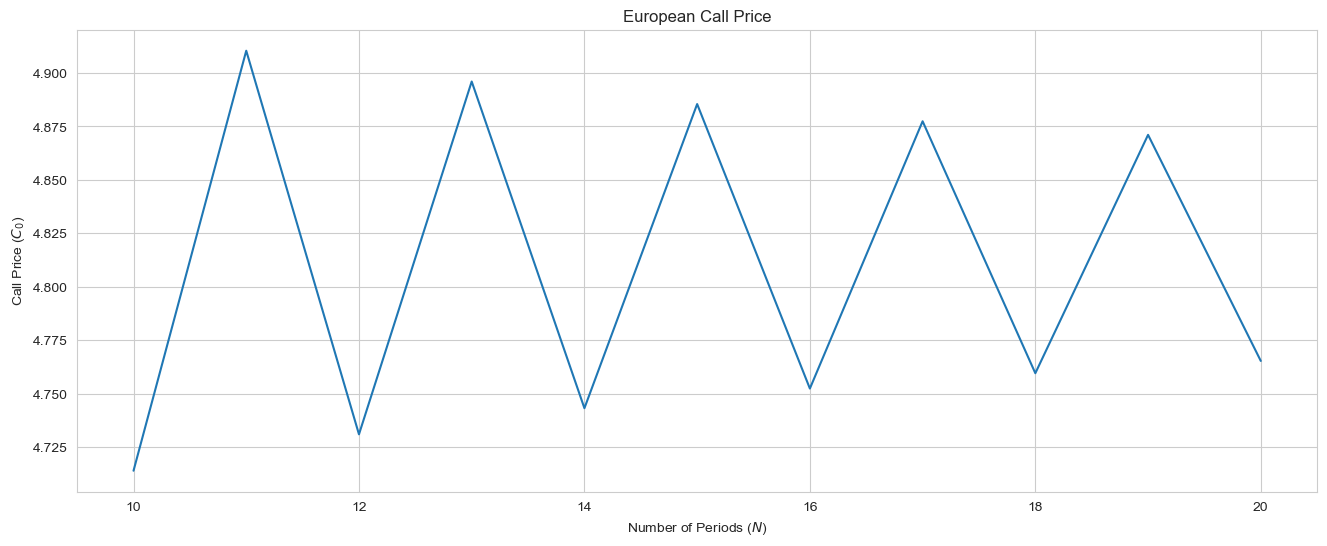

In [3]:
calls = np.zeros(11)
for n in range(10, 21):
    calls[n - 10] = euro_call_tree(S0=50, sigma=0.3,
                                   T=0.5, K=50, r=0.05, N=n)[0, 0]
# plot
fig, ax = plt.subplots()
ax.plot(range(10, 21), calls)
plt.xlabel(r"Number of Periods ($N$)")
plt.ylabel(r"Call Price ($C_0$)")
plt.title("European Call Price")
plt.show()

## Question 5.2

In [4]:
def Black_Scholes_Call(S, K, r, T, sigma, q=0):
    """Black-Scholes call option price

    Args:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free rate
        T (float): time to maturity
        sigma (float): volatility
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        float: Black-Scholes (European) call option price
    """
    if sigma == 0:
        return max(S * np.exp(-q * T) - K * np.exp(-r * T), 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [5]:
call_price_bs = Black_Scholes_Call(S=50, K=50, r=0.05, T=0.5, sigma=0.3)
display(
    Markdown("Black-Scholes Call Price: $C_0 = {:.4f}$".format(call_price_bs)))

Black-Scholes Call Price: $C_0 = 4.8174$

In [6]:
n = 10
while True:
    call_price_tree = euro_call_tree(
        S0=50, sigma=0.3, T=0.5, K=50, r=0.05, N=n)[0, 0]
    if abs(call_price_bs - call_price_tree) < 0.01:  # penny accuracy (0.01)
        display(Markdown("Number of periods to get penny accuracy: $N = {}$".format(n)))
        break
    n += 1

Number of periods to get penny accuracy: $N = 103$

## Question 5.3

In [7]:
def euro_put_tree(S0, sigma, T, N, K, r, q=0):
    """European put option price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps
        K (float): strike price
        r (float): risk-free rate
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        numpy.ndarray: European put option price tree
    """
    S = stock_tree(S0, sigma, T, N)
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)  # risk-neutral probability
    euro_put = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        euro_put[i, N] = max(K - S[i, N], 0)
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            euro_put[i, t] = np.exp(-r * dt) * (p * euro_put[i,
                                                             t + 1] + (1 - p) * euro_put[i + 1, t + 1])
    return euro_put


def american_put_tree(S0, sigma, T, N, K, r, q=0):
    """American put option price tree

    Args:
        S0 (float): initial stock price
        sigma (float): volatility
        T (float): time to maturity
        N (int): number of steps
        K (float): strike price
        r (float): risk-free rate
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        numpy.ndarray: American put option price tree
    """
    S = stock_tree(S0, sigma, T, N)
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)  # risk-neutral probability
    american_put = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        american_put[i, N] = max(K - S[i, N], 0)  # payoff at maturity
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            american_put[i, t] = max(
                K - S[i, t],
                np.exp(-r * dt) * (p *
                                   american_put[i, t + 1] + (1 - p) * american_put[i + 1, t + 1]),
            )  # allowing early exercise
    return american_put

In [8]:
early_exercise_premium = (american_put_tree(S0=50, sigma=0.3, T=1, N=500, K=50, r=0.05, q=0.02)[0, 0] -
                          euro_put_tree(S0=50, sigma=0.3, T=1, N=500, K=50, r=0.05, q=0.02)[0, 0])
display(Markdown("Early Exercise Premium: {:.4f}".format(
    early_exercise_premium)))

Early Exercise Premium: 0.1752

## 5.5

In [9]:
def MC_Heston(S0, K, T, r, v0, kappa, theta, gamma, rho, N, M, q=0):
    """Monte Carlo simulation for Heston model

    Args:
        S0 (float): initial stock price
        K (float): strike price
        T (float): time to maturity
        r (float): risk-free rate
        v0 (float): initial variance
        kappa (float): mean reversion speed
        theta (float): mean reversion level
        gamma (float): volatility of variance
        rho (float): correlation between stock price and variance
        N (int): number of steps
        M (int): number of paths
        q (float, optional): dividend yields. Defaults to 0.

    Returns:
        float: Heston call option price
    """
    dt = T / N  # time step
    logS = np.zeros((M, N + 1))  # log stock price paths
    v = np.zeros((M, N + 1))  # variance paths
    logS[:, 0] = np.log(S0)  # initial stock price
    v[:, 0] = v0  # initial variance
    for i in range(1, N + 1):
        Z1 = rng.standard_normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * rng.standard_normal(size=M)
        logS[:, i] = logS[:, i - 1] + \
            (r - q - 0.5 * v[:, i - 1]) * dt + np.sqrt(v[:, i - 1] * dt) * Z1
        v[:, i] = np.maximum(v[:, i - 1] + kappa * (theta - v[:, i - 1])
                             * dt + gamma * np.sqrt(v[:, i - 1] * dt) * Z2, 0)
    call_mean = np.mean(
        np.exp(-r * T) * np.maximum(np.exp(logS[:, -1]) - K, 0))
    call_std = np.std(
        np.exp(-r * T) * np.maximum(np.exp(logS[:, -1]) - K, 0)) / np.sqrt(M)
    return call_mean, call_std

In [10]:
call_mean, call_std = MC_Heston(
    S0=100,
    K=100,
    T=1,
    r=0.01,
    v0=0.09,
    kappa=0.2,
    theta=0.5,
    gamma=0.1,
    rho=-0.6,
    N=100,
    M=1000,
)
display(Markdown(f"Heston Call Price: ${call_mean:.4f} \pm {call_std:.4f}$"))

Heston Call Price: $14.1308 \pm 0.7552$